# Introduction

In this project, you will build a neural network of your own design to evaluate the MNIST dataset.

Some of the benchmark results on MNIST include can be found [on Yann LeCun's page](http://yann.lecun.com/exdb/mnist/) and include:

88% [Lecun et al., 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)
95.3% [Lecun et al., 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)
99.65% [Ciresan et al., 2011](http://people.idsia.ch/~juergen/ijcai2011.pdf)

MNIST is a great dataset for sanity checking your models, since the accuracy levels achieved by large convolutional neural networks and small linear models are both quite high. This makes it important to be familiar with the data.

## Imports

In [1]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [7]:
import os
import shutil
import time

from torch.utils.tensorboard import SummaryWriter

BASE_DIR = '/home/nd101-p1/'
RANDOM_STATE = 17
BATCH_SIZE = 64

torch.manual_seed(RANDOM_STATE)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

writer = SummaryWriter(log_dir=os.path.join(BASE_DIR, 'runs'))

## Load the Dataset

Specify your transforms as a list if you intend to .
The transforms module is already loaded as `transforms`.

MNIST is fortunately included in the torchvision module.
Then, you can create your dataset using the `MNIST` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/vision/stable/datasets.html#mnist)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [8]:
# Define transforms
## YOUR CODE HERE ##

train_transform = transforms.Compose([
    transforms.ColorJitter(brightness=0.05, contrast=0.05, saturation=0.05, hue=0.05),
    transforms.RandomAffine(degrees=10, translate=(.20,.20), scale=(.9,1.1)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
     # transforms.Lambda(torch.flatten)
    ])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
     # transforms.Lambda(torch.flatten)
    ])

# Create training set and define training dataloader
## YOUR CODE HERE ##
train_data = torchvision.datasets.MNIST(
    root=BASE_DIR,
    train=True, 
    transform=train_transform, 
    download=True)

train_size = int(0.8 * len(train_data))
val_size = len(train_data) - train_size
train_data, val_data = torch.utils.data.random_split(train_data, [train_size, val_size])

train_loader = torch.utils.data.DataLoader(
    train_data,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4)

val_loader = torch.utils.data.DataLoader(
    val_data,
    batch_size=BATCH_SIZE,
    num_workers=4)

# Create test set and define test dataloader
## YOUR CODE HERE ##
test_data = torchvision.datasets.MNIST(
    root=BASE_DIR,
    train=False, 
    transform=test_transform, 
    download=True)

test_loader = torch.utils.data.DataLoader(
    test_data,
    batch_size=BATCH_SIZE,
    num_workers=4)

## Justify your preprocessing

In your own words, why did you choose the transforms you chose? If you didn't use any preprocessing steps, why not?

The augmented training set will result in a more generalized trained model. Using `transforms.ColorJitter` helps to make the model more robust to color noise. Also, using `transforms.RandomAffine`, we can make a more robust model for the structural variation of the letter. 

The flattening of input data make `show5` function unavailable by the input format missmatch. Instead, we can flatten the data using `view(-1, 784)` in the model.

## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [9]:
## This cell contains a function for showing 5 images from a dataloader – DO NOT CHANGE THE CONTENTS! ##
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(int(labels[i].detach()))
    
        image = images[i].numpy()
        plt.imshow(image.T.squeeze().T)
        plt.show()

5


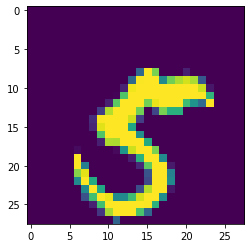

2


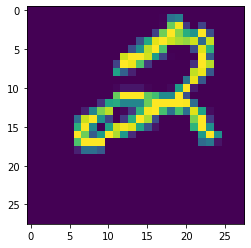

8


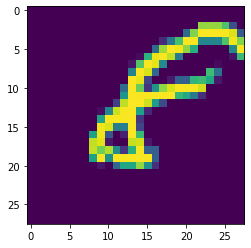

8


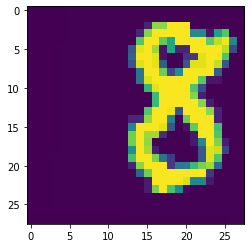

4


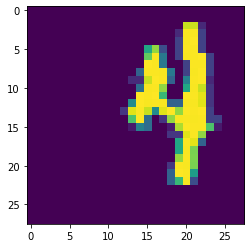

In [10]:
# Explore data
## YOUR CODE HERE ##
show5(train_loader)

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset.
Use any architecture you like. 

*Note*: If you did not flatten your tensors in your transforms or as part of your preprocessing and you are using only `Linear` layers, make sure to use the `Flatten` layer in your network!

In [16]:
## YOUR CODE HERE ##
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(784, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 32)
        self.fc6 = nn.Linear(32, 10)

    def forward(self, x):
        x = x.float()
        x = F.relu(self.fc1(x.view(-1, 784)))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = self.fc6(x)
        return x


model = Net().to(device)

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [17]:
## YOUR CODE HERE ##
optimizer = optim.AdamW(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss **during** each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [13]:
## YOUR CODE HERE ##
num_epohcs = 8

train_loss_epoch = []
train_acc_epoch = []
val_loss_epoch = []
val_acc_epoch = []

# log_dir = os.path.join(BASE_DIR, 'runs')
# if os.path.exists(log_dir):
#     shutil.rmtree(log_dir, ignore_errors=True)

for epoch in range(1, num_epohcs + 1):
    model.train()
    train_loss = 0.0
    train_correct = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        # grid = torchvision.utils.make_grid(data)
        # writer.add_image("images", grid)
        # writer.add_graph(model, data)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        # if batch_idx % 250 == 0:
        #     print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        #         epoch, batch_idx * len(data), len(train_loader.dataset),
        #         100. * batch_idx / len(train_loader), loss.item()))
        
        pred = output.argmax(dim=1, keepdim=True)
        train_correct += pred.eq(target.view_as(pred)).sum().item()
        train_loss += loss.item()

    train_loss_epoch.append(train_loss / len(train_loader))
    train_acc_epoch.append(train_correct / len(train_loader))
    writer.add_scalar('Loss/train', train_loss_epoch[-1], epoch)
    writer.add_scalar('Accuracy/train', train_acc_epoch[-1], epoch)

    val_loss = 0.0
    val_correct = 0
    model.eval()
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_loader):
            data, target = data.to(device), target.to(device)

            # grid = torchvision.utils.make_grid(data)
            # writer.add_image("images", grid)
            # writer.add_graph(model, data)

            output = model(data)
            loss = criterion(output, target)
            pred = output.argmax(dim=1, keepdim=True)
            
            val_correct += pred.eq(target.view_as(pred)).sum().item()
            val_loss += loss.item()

    val_loss_epoch.append(val_loss / len(val_loader))
    val_acc_epoch.append(val_correct / len(test_loader))
    writer.add_scalar("Loss/val", val_loss_epoch[-1], epoch)
    writer.add_scalar("Accuracy/val", val_acc_epoch[-1], epoch)

    print(
        f'Epoch {epoch} train acc: {train_acc_epoch[-1]:.2f}', 
        f'validatoin acc: {val_acc_epoch[-1]:.2f}')

writer.flush()
writer.close()

Epoch 1 train acc: 36.51 validatoin acc: 56.11
Epoch 2 train acc: 50.32 validatoin acc: 61.92
Epoch 3 train acc: 52.61 validatoin acc: 64.46
Epoch 4 train acc: 53.98 validatoin acc: 65.34
Epoch 5 train acc: 55.04 validatoin acc: 65.36
Epoch 6 train acc: 55.06 validatoin acc: 65.97
Epoch 7 train acc: 55.75 validatoin acc: 67.12
Epoch 8 train acc: 55.94 validatoin acc: 67.28


Plot the training loss (and validation loss/accuracy, if recorded).

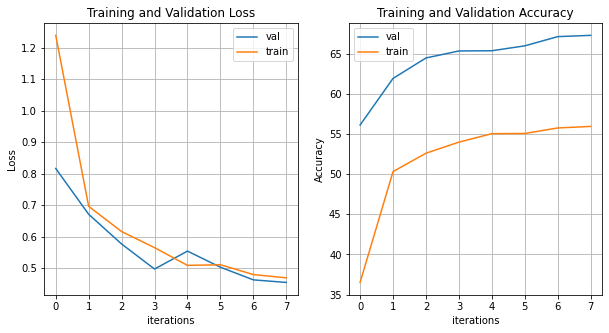

In [14]:
## YOUR CODE HERE ##
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title("Training and Validation Loss")
plt.plot(val_loss_epoch,label="val")
plt.plot(train_loss_epoch,label="train")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.grid()
plt.legend()

plt.subplot(1, 2, 2)
plt.title("Training and Validation Accuracy")
plt.plot(val_acc_epoch,label="val")
plt.plot(train_acc_epoch,label="train")
plt.xlabel("iterations")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()


## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 90%, great work, but see if you can push a bit further! 
If your accuracy is under 90%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [15]:
## YOUR CODE HERE ##
model.eval()
test_loss = 0
correct = 0
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        test_loss += criterion(output, target)  # sum up batch loss
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()

test_loss /= len(test_loader.dataset)

print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))


Test set: Average loss: 0.0049, Accuracy: 9186/10000 (91.86%)



## Improving your model

Once your model is done training, try tweaking your hyperparameters and training again below to improve your accuracy on the test set!

Use a smaller learning rate for a smooth decrease of loss.

The `optim.Adam` shows a little better accuracy than `optim.AdamW`.

In [31]:
## YOUR CODE HERE ##
model = Net().to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

Train with longer epochs to compensate for the smaller learning rate.

In [32]:
## YOUR CODE HERE ##
num_epohcs = 16

train_loss_epoch = []
train_acc_epoch = []
val_loss_epoch = []
val_acc_epoch = []

# log_dir = os.path.join(BASE_DIR, 'runs')
# if os.path.exists(log_dir):
#     shutil.rmtree(log_dir, ignore_errors=True)

for epoch in range(1, num_epohcs + 1):
    model.train()
    train_loss = 0.0
    train_correct = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        # grid = torchvision.utils.make_grid(data)
        # writer.add_image("images", grid)
        # writer.add_graph(model, data)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        # if batch_idx % 250 == 0:
        #     print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        #         epoch, batch_idx * len(data), len(train_loader.dataset),
        #         100. * batch_idx / len(train_loader), loss.item()))
        
        pred = output.argmax(dim=1, keepdim=True)
        train_correct += pred.eq(target.view_as(pred)).sum().item()
        train_loss += loss.item()

    train_loss_epoch.append(train_loss / len(train_loader))
    train_acc_epoch.append(train_correct / len(train_loader))
    writer.add_scalar('Loss/train', train_loss_epoch[-1], epoch)
    writer.add_scalar('Accuracy/train', train_acc_epoch[-1], epoch)

    val_loss = 0.0
    val_correct = 0
    model.eval()
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_loader):
            data, target = data.to(device), target.to(device)

            # grid = torchvision.utils.make_grid(data)
            # writer.add_image("images", grid)
            # writer.add_graph(model, data)

            output = model(data)
            loss = criterion(output, target)
            pred = output.argmax(dim=1, keepdim=True)
            
            val_correct += pred.eq(target.view_as(pred)).sum().item()
            val_loss += loss.item()

    val_loss_epoch.append(val_loss / len(val_loader))
    val_acc_epoch.append(val_correct / len(test_loader))
    writer.add_scalar("Loss/val", val_loss_epoch[-1], epoch)
    writer.add_scalar("Accuracy/val", val_acc_epoch[-1], epoch)

    print(
        f'Epoch {epoch} train acc: {train_acc_epoch[-1]:.2f}', 
        f'validatoin acc: {val_acc_epoch[-1]:.2f}')

writer.flush()
writer.close()

Epoch 1 train acc: 43.41 validatoin acc: 64.92
Epoch 2 train acc: 56.54 validatoin acc: 68.26
Epoch 3 train acc: 58.16 validatoin acc: 70.10
Epoch 4 train acc: 58.95 validatoin acc: 70.64
Epoch 5 train acc: 59.47 validatoin acc: 71.05
Epoch 6 train acc: 59.81 validatoin acc: 71.62
Epoch 7 train acc: 60.06 validatoin acc: 72.00
Epoch 8 train acc: 60.29 validatoin acc: 71.37
Epoch 9 train acc: 60.51 validatoin acc: 71.76
Epoch 10 train acc: 60.58 validatoin acc: 72.39
Epoch 11 train acc: 60.74 validatoin acc: 72.55
Epoch 12 train acc: 60.83 validatoin acc: 72.34
Epoch 13 train acc: 60.95 validatoin acc: 72.64
Epoch 14 train acc: 60.97 validatoin acc: 72.66
Epoch 15 train acc: 60.96 validatoin acc: 73.34
Epoch 16 train acc: 61.19 validatoin acc: 72.96


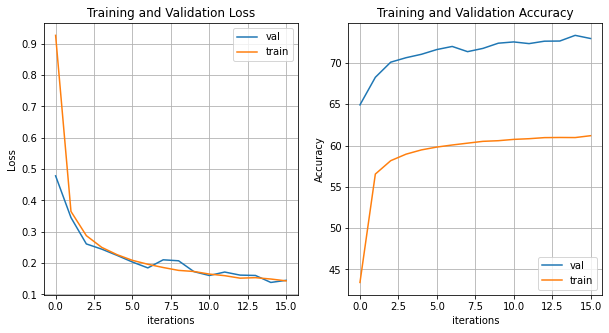

In [33]:
## YOUR CODE HERE ##
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title("Training and Validation Loss")
plt.plot(val_loss_epoch,label="val")
plt.plot(train_loss_epoch,label="train")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.grid()
plt.legend()

plt.subplot(1, 2, 2)
plt.title("Training and Validation Accuracy")
plt.plot(val_acc_epoch,label="val")
plt.plot(train_acc_epoch,label="train")
plt.xlabel("iterations")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()

In [34]:
## YOUR CODE HERE ##
model.eval()
test_loss = 0
correct = 0
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        test_loss += criterion(output, target)  # sum up batch loss
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()

test_loss /= len(test_loader.dataset)

print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))


Test set: Average loss: 0.0012, Accuracy: 9751/10000 (97.51%)



## Saving your model
Using `torch.save`, save your model for future loading.

In [36]:
## YOUR CODE HERE ##
timestr = time.strftime("%Y%m%d%H%M%S")
torch.save(model.state_dict(), os.path.join('/home/nd101-p1/', f"mnist-{timestr}.pt"))